In [4]:
!pip install dgl

  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [1]:
import os # for interact with system
import torch # pytorch
os.environ['TORCH'] = torch.__version__
print(torch.__version__) # check what version of pytorch

# install libaries for pytorch geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.12.1+cu113
     |████████████████████████████████| 7.9 MB 2.8 MB/s 
     |████████████████████████████████| 3.5 MB 2.8 MB/s 


In [5]:
import dgl # it provides graph dataset to work with
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In graph neural network(GNN), link/edge level prediction means to find a connection between two nodes. </br>
There are some important notes to do link prediction: </br>
1. select graph's existing edges as positive sample(s)
2. select graph's non-existing edges as negative sample(s)
3. positive sample = training set; negative sample = testing set
4. In evaluation, we can use AUC to check the performance of the model.



In [6]:
import dgl.data
dataset = dgl.data.CoraGraphDataset() # dataset contains graph list
g = dataset[0] # select a single graph

Extracting file to /root/.dgl/cora_v2
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


In [7]:
# split data into training set and testing set
u, v = g.edges()
eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1) 
train_size = g.number_of_edges() 
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

In [8]:
# check test positve sample
test_pos_u

tensor([ 889, 1441,  385,  ..., 2166,  783,  154])

In [10]:
test_pos_v

tensor([1830,  371, 2483,  ..., 1029,  638, 1444])

In [11]:
# check training positve sample
train_pos_u

tensor([289, 670, 507,  ..., 408,  51, 102])

In [13]:
# collect all negative samples
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

In [14]:
neg_eids = np.random.choice(len(neg_u), g.number_of_edges() // 2)
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

Positve data: are data would not causing warrning; negative data would causing warrning. </br>
Accuracy = true warring y(label) / predicted warrning y


In [15]:
# check negative sample
train_neg_u

array([1030, 1021,  121, ...,  509, 2422, 1079])

In [16]:
# when we training the model, we need to remove 10% of traing sample
# the purpose is to prevent data leakage
train_g = dgl.remove_edges(g, eids[:test_size])

GraphSage is a tool for graph embedding. 
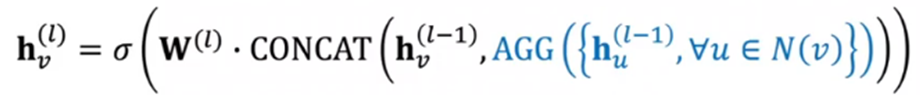

h is embedding; hv = self-message; hu = neighbors messages; W just transformation; AGG = Graph aggregation; CON = concatenate 

In [17]:
# define a two layers GraphSage model
from dgl.nn import SAGEConv

class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

what we need to do is to predict an edge's point between two nodes. Based on the point/score, we can determine wheater an edge exists between two nodes or not; in other words, we try to find characterization of an edge.

dgl.graph conversion: we need to convert pistive samples and negative samples into dgl.graph format, so that it's easier to compute.

In [18]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

In order to compute the point/score between nodes, we need to define a function. (or we can directly use pre-defined funciton from: https://docs.dgl.ai/tutorials/blitz/5_graph_classification.html#sphx-glr-tutorials-blitz-5-graph-classification-py)

In [19]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # use dot product, find similarity score between source's h(embedding) and target's 
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # we need to reduce dimension
            return g.edata['score'][:, 0]

In [21]:
model = GraphSAGE(train_g.ndata['feat'].shape[1], 16)

In [23]:
# prediction
pred = DotPredictor()

In [24]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

In [25]:
# entropy loss
def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

# compute Area under the curve score
def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [26]:
all_logits = []
for e in range(100):
    # forward 
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

# print the preformance
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))

/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In epoch 0, loss: 0.6926373243331909
In epoch 5, loss: 0.6263169646263123
In epoch 10, loss: 0.6049462556838989
In epoch 15, loss: 0.578560471534729
In epoch 20, loss: 0.5326451659202576
In epoch 25, loss: 0.4657936692237854
In epoch 30, loss: 0.41471266746520996
In epoch 35, loss: 0.36714237928390503
In epoch 40, loss: 0.3382253348827362
In epoch 45, loss: 0.30784401297569275
In epoch 50, loss: 0.2805817425251007
In epoch 55, loss: 0.2601359486579895
In epoch 60, loss: 0.2385009080171585
In epoch 65, loss: 0.21912777423858643
In epoch 70, loss: 0.20076051354408264
In epoch 75, loss: 0.18232424557209015
In epoch 80, loss: 0.1645982414484024
In epoch 85, loss: 0.1476486325263977
In epoch 90, loss: 0.131202831864357
In epoch 95, loss: 0.11558180302381516
AUC 0.8727333168617057
